# Compare PODs of different read outs

The Axiom dataset contains CellPainting morphology data, plus various readouts related to cell viability / cytotoxicity. We computed points-of-departure (PODs) for each data type. Here, we compare PODs between: morphology, cell count, MTT, and LDH.

CellPainting morphological endpoints reflect many biological processes. The remainder are various viability endpoints. MTT reflects the metabolic capacity of a given group of cells. Since more cells = more metabolism, it is usually correlated with cell count, however there can be metabolic impacts prior to cell death. Cell count reflects the combined effects of cell death and cell proliferation. Since hepatocytes are mainly non-dividing, we expect it to mainly reflect cell death. LDH is an enzyme released during necrosis, so it reflects a subset of cell death. 

We expect that CellPainting will have hits for the most compounds, next MTT, next cell count, and finally LDH. We expect that every LDH compound is included in the cell count compounds, and that the {LDH, cell count} compounds are also detected by CellPainting and MTT. We also expect the same general trend when comparing the actual POD values, where the sensitivity will be in the order CellPainting > MTT > cell count > LDH. 

In [1]:
import polars as pl
import pandas as pd
from upsetplot import plot

In [2]:
# Compile all PODs into one dataframe
feat_path = "../1_snakemake/outputs/dino/mad_featselect"
prof_path = f"{feat_path}/profiles/mad_featselect.parquet"

data = pl.read_parquet(prof_path)

cc = pl.read_parquet(f"{feat_path}/curves/ccpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_cc_POD"})
ldh = pl.read_parquet(f"{feat_path}/curves/ldhpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_ldh_POD"})
mtt = pl.read_parquet(f"{feat_path}/curves/mttpods.parquet").filter(pl.col("all.pass") == True).select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_mtt_POD"})
morph = pl.read_parquet(f"{feat_path}/curves/pods.parquet").select(["Metadata_Compound", "bmd"]).rename({"bmd": "Metadata_morph_POD"})

data = data.join(cc, on="Metadata_Compound", how="left")
data = data.join(ldh, on="Metadata_Compound", how="left")
data = data.join(mtt, on="Metadata_Compound", how="left")
data = data.join(morph, on="Metadata_Compound", how="left")

all_pods = data.select([
    "Metadata_Compound",
    "Metadata_cc_POD",
    "Metadata_ldh_POD",
    "Metadata_mtt_POD",
    "Metadata_morph_POD",
]).unique()

## Make Upset plot of intersects between lists

In [4]:
morph_set = set(all_pods.filter(~pl.col("Metadata_morph_POD").is_nan()).select("Metadata_Compound").to_series().to_list())
mtt_set = set(all_pods.filter(~pl.col("Metadata_mtt_POD").is_nan()).select("Metadata_Compound").to_series().to_list())
cc_set = set(all_pods.filter(~pl.col("Metadata_cc_POD").is_nan()).select("Metadata_Compound").to_series().to_list())
ldh_set = set(all_pods.filter(~pl.col("Metadata_ldh_POD").is_nan()).select("Metadata_Compound").to_series().to_list())

all_sets = [morph_set, mtt_set, cc_set, ldh_set]
set_labels = ['Morphology', 'MTT', 'Cell count', 'LDH']

# Create a mapping of element to set memberships
element_to_sets = {}
for i, s in enumerate(all_sets):
    for elem in s:
        if elem not in element_to_sets:
            element_to_sets[elem] = [0] * len(all_sets)
        element_to_sets[elem][i] = 1

# Convert mapping into a DataFrame
rows = []
for elem, membership in element_to_sets.items():
    rows.append(membership)
df = pd.DataFrame(rows, columns=set_labels)

# Group by sets and count occurrences
df['value'] = 1
upset_input = df.groupby(set_labels).count()
upset_input = upset_input['value']

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

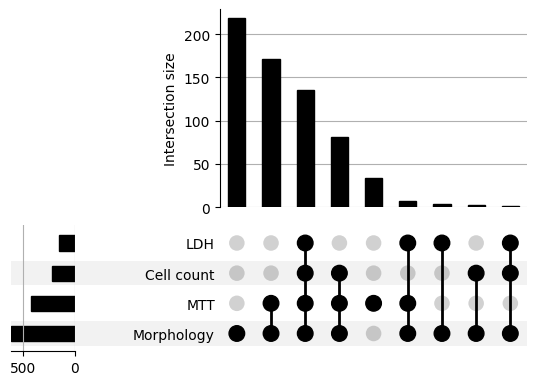

In [5]:
plot(upset_input, sort_by="cardinality") 

This plot shows that:

1) LDH & cell count hits are also detected by morphology (every hit) and MTT (8 exceptions)
2) There are many compounds detected by morphology but not by any other assay (n = 218)
3) There are also many compounds detected by only morphology and MTT (n = 171)
4) There are a small set of compounds detected by only MTT, but not by morphology (n = 34)

## Scatterplots comparing PODs

After comparing POD values, we see exactly what we expect in most cases: morphology < MTT < cell count < LDH. There are a fair number of cases where the MTT POD is lower than the morphology POD (125/394, 32%), however keep in mind that there were many compounds with only morphology PODs (n = 218) versus compounds with only MTT PODs (n = 34).

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 692 rows containing missing values.


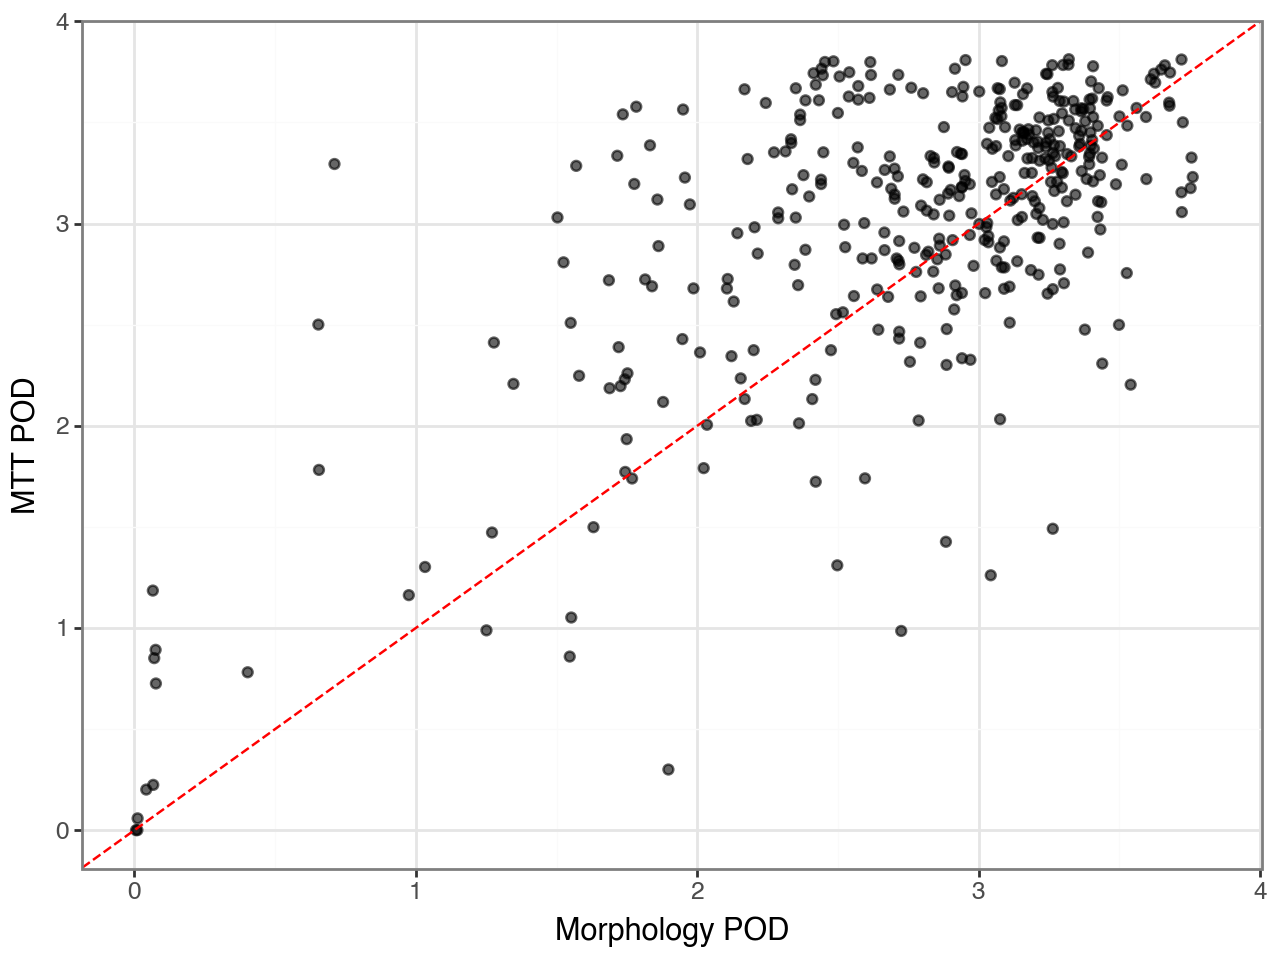

/var/folders/g0/nk06fpgs01z6zmr4x7kvp0g80000gp/T/ipykernel_39348/563485050.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 866 rows containing missing values.


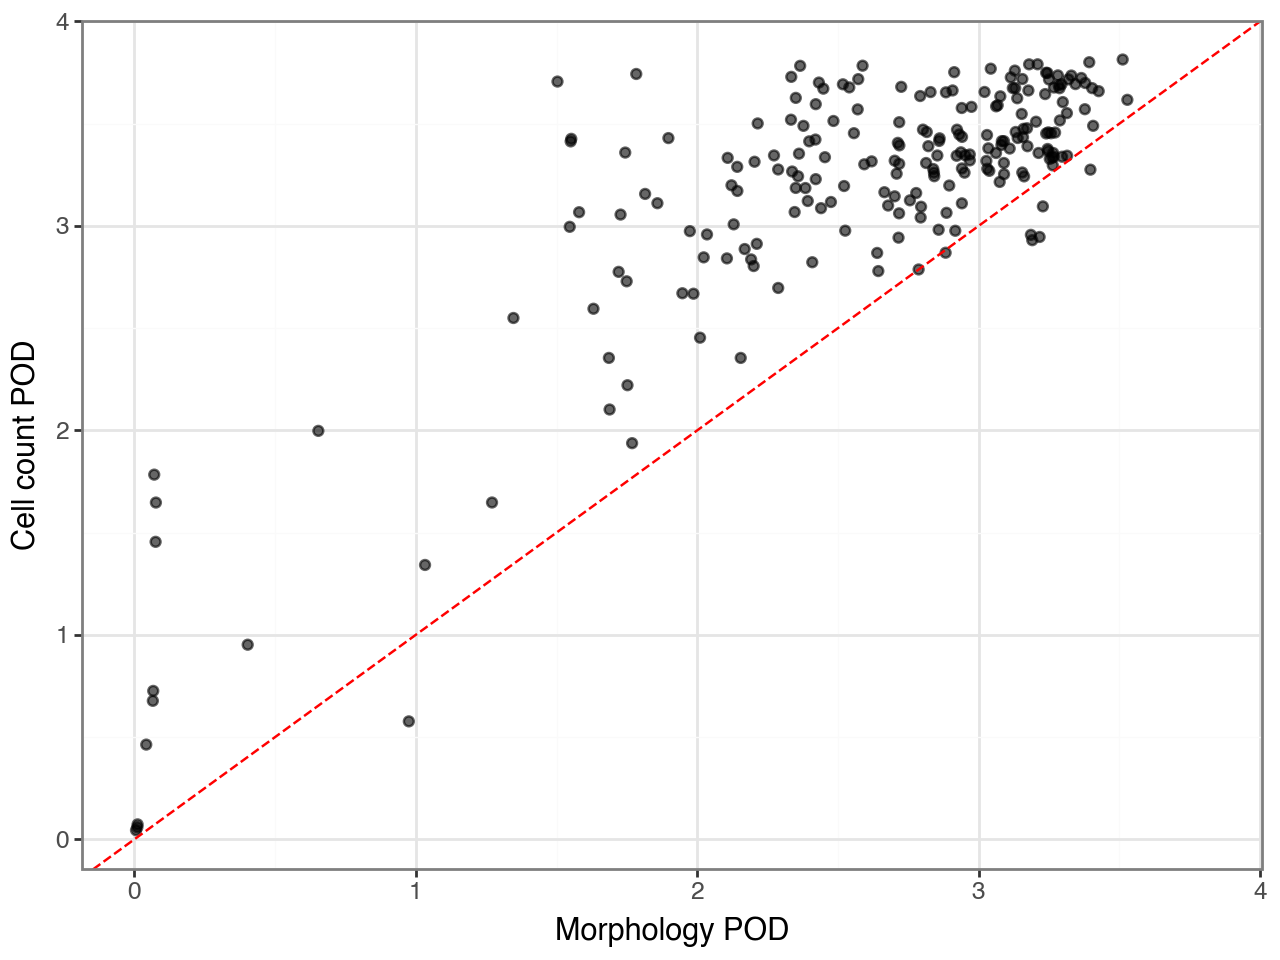

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 939 rows containing missing values.


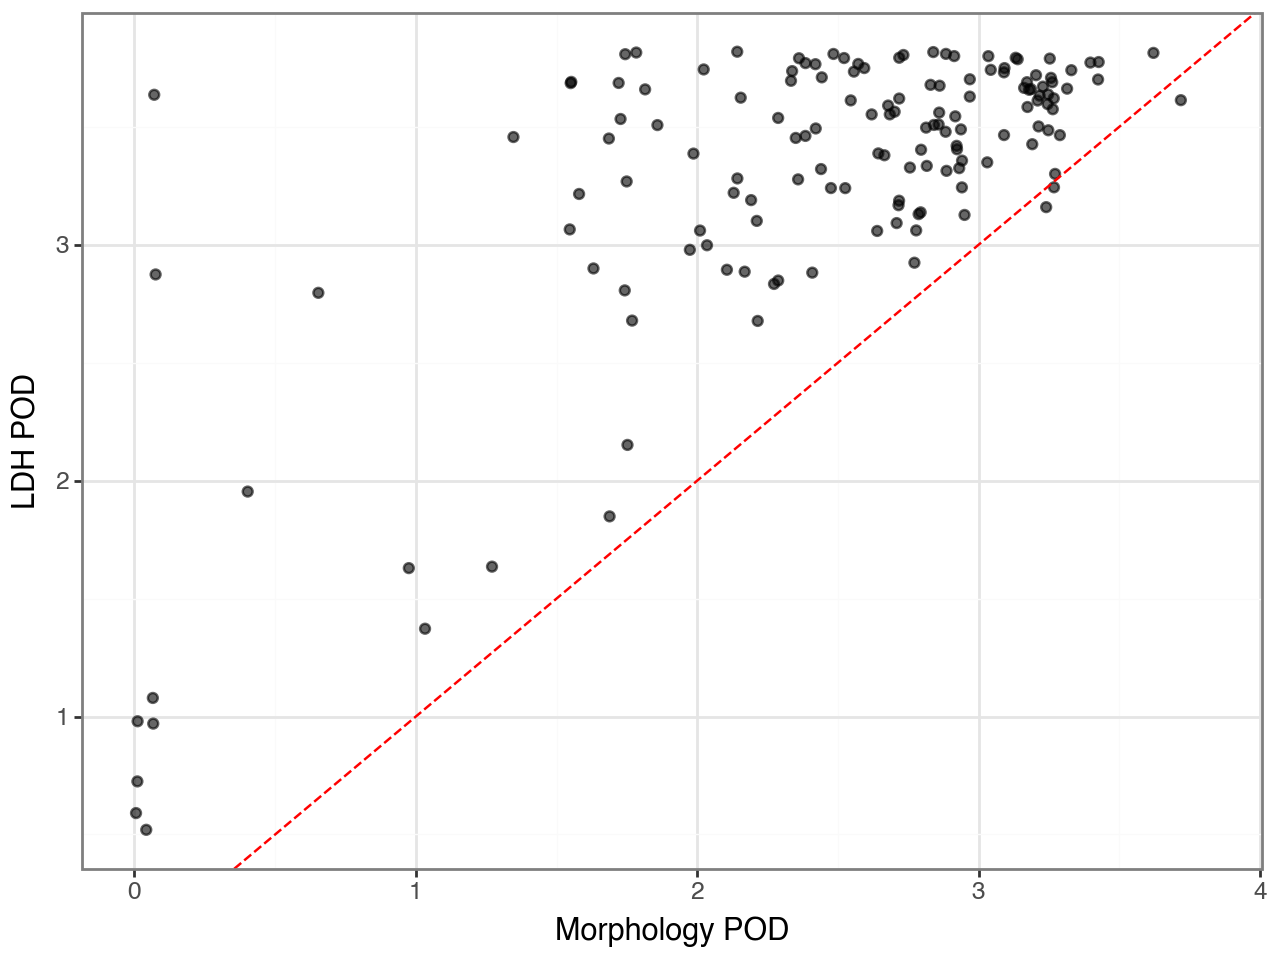

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 870 rows containing missing values.


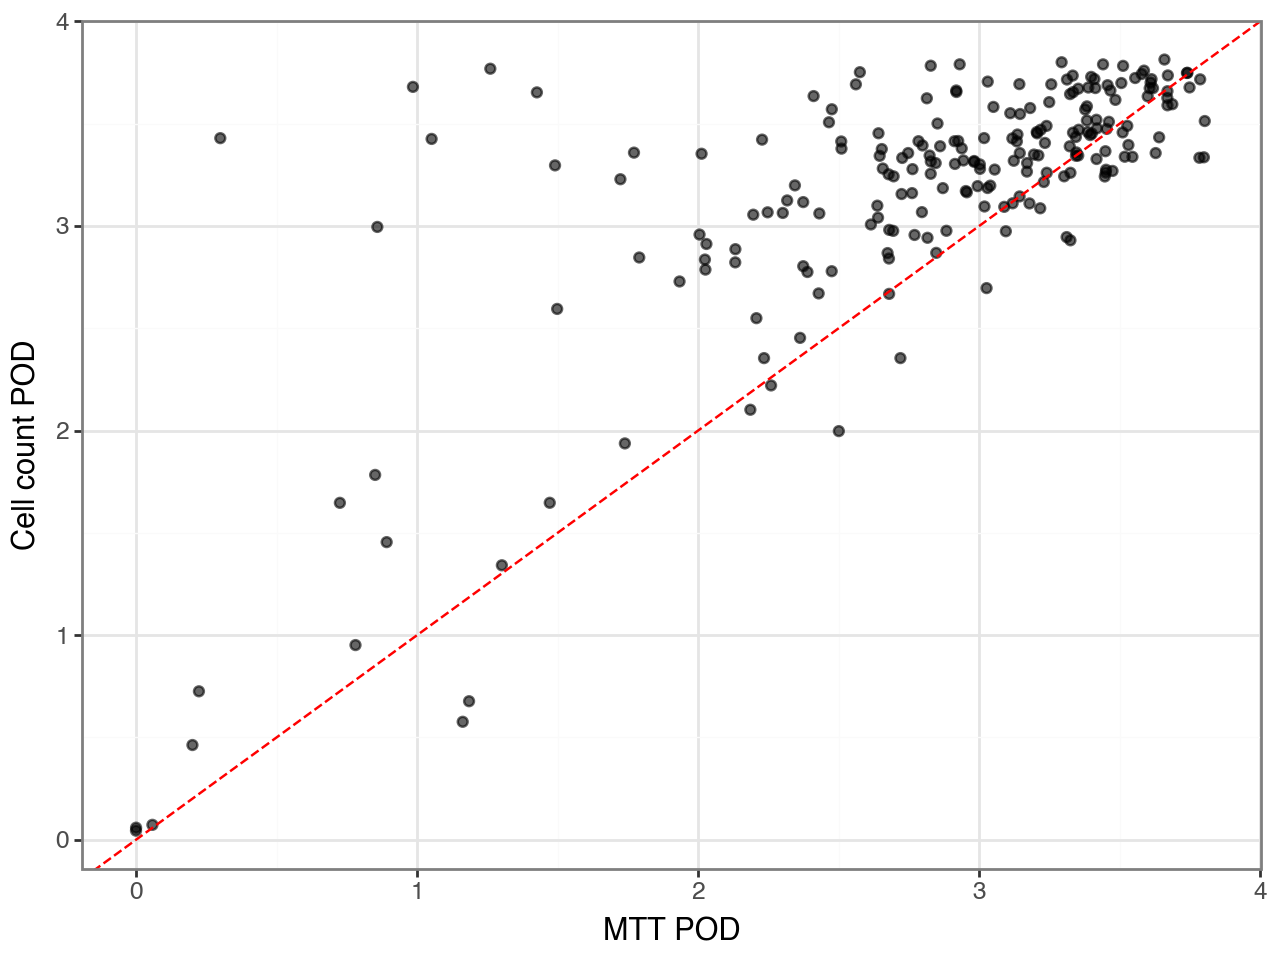

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 944 rows containing missing values.


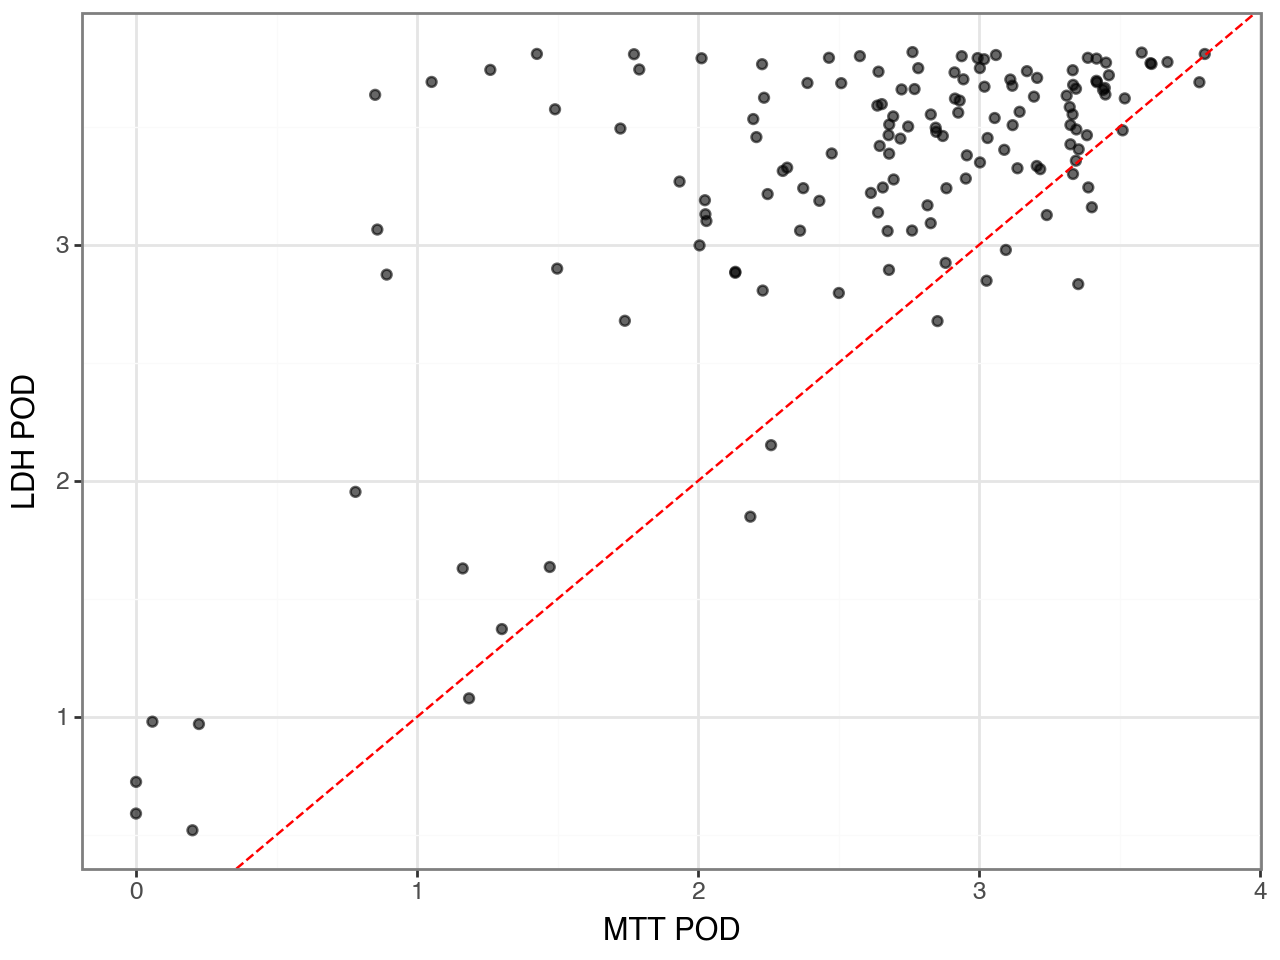

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 950 rows containing missing values.


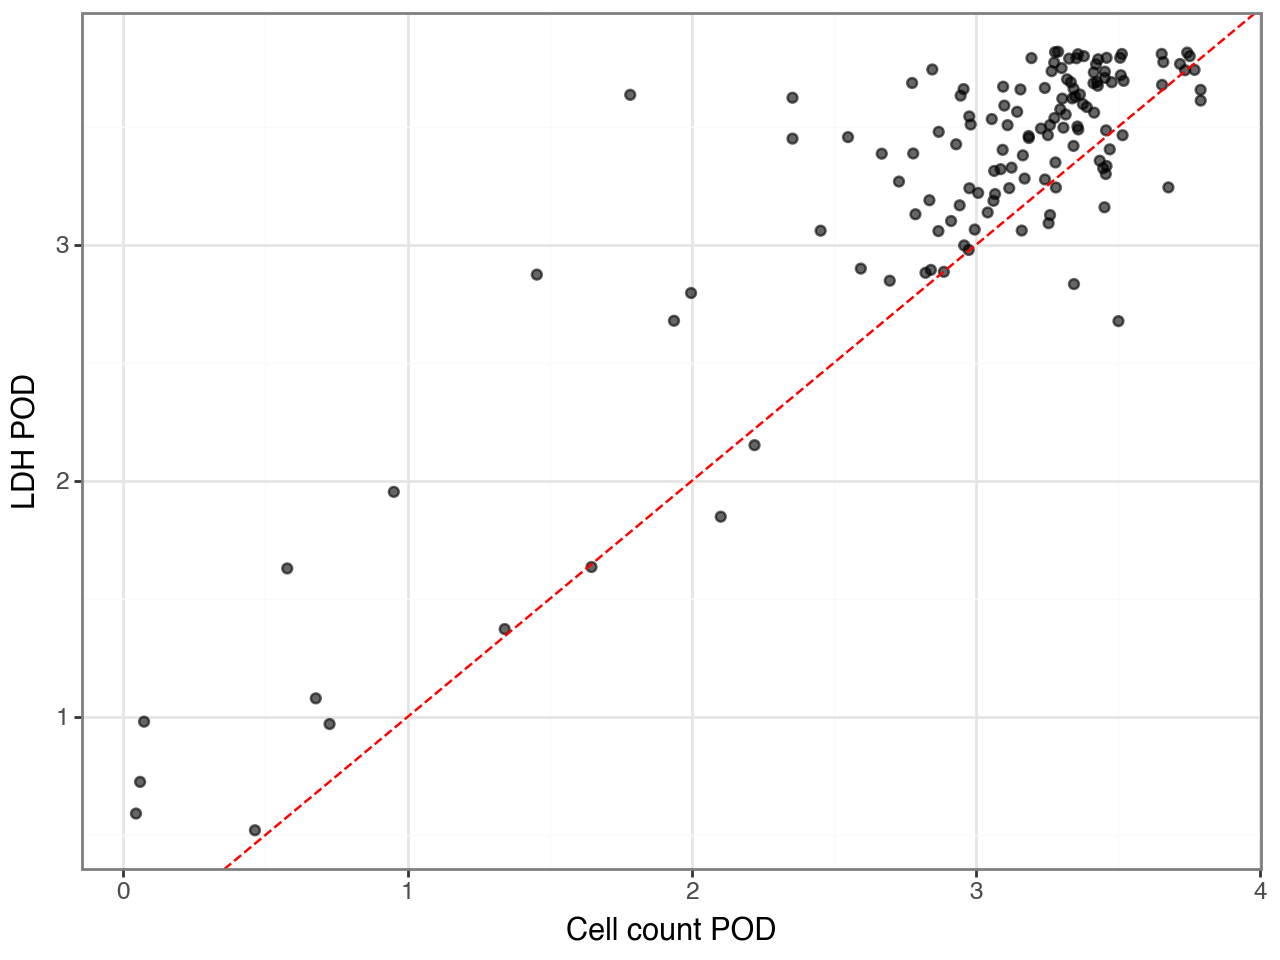

In [8]:
from plotnine import ggplot, aes, geom_point, labs, theme_bw, geom_abline

plot = (
    ggplot(all_pods, aes(x='Metadata_morph_POD', y='Metadata_mtt_POD')) +
    geom_point(alpha=0.6) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='red') +
    labs(
        x='Morphology POD',
        y='MTT POD'
    ) +
    theme_bw()
)
plot.show()

plot = (
    ggplot(all_pods, aes(x='Metadata_morph_POD', y='Metadata_cc_POD')) +
    geom_point(alpha=0.6) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='red') +
    labs(
        x='Morphology POD',
        y='Cell count POD'
    ) +
    theme_bw()
)
print(plot)

plot = (
    ggplot(all_pods, aes(x='Metadata_morph_POD', y='Metadata_ldh_POD')) +
    geom_point(alpha=0.6) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='red') +
    labs(
        x='Morphology POD',
        y='LDH POD'
    ) +
    theme_bw()
)
plot.show()

plot = (
    ggplot(all_pods, aes(x='Metadata_mtt_POD', y='Metadata_cc_POD')) +
    geom_point(alpha=0.6) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='red') +
    labs(
        x='MTT POD',
        y='Cell count POD'
    ) +
    theme_bw()
)
plot.show()

plot = (
    ggplot(all_pods, aes(x='Metadata_mtt_POD', y='Metadata_ldh_POD')) +
    geom_point(alpha=0.6) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='red') +
    labs(
        x='MTT POD',
        y='LDH POD'
    ) +
    theme_bw()
)
plot.show()

plot = (
    ggplot(all_pods, aes(x='Metadata_cc_POD', y='Metadata_ldh_POD')) +
    geom_point(alpha=0.6) +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='red') +
    labs(
        x='Cell count POD',
        y='LDH POD'
    ) +
    theme_bw()
)
plot.show()

In [16]:
diff = (all_pods.select(["Metadata_morph_POD", "Metadata_mtt_POD"])
    .filter(~pl.col("Metadata_morph_POD").is_nan())
    .filter(~pl.col("Metadata_mtt_POD").is_nan())
    .with_columns((pl.col("Metadata_morph_POD") - pl.col("Metadata_mtt_POD")).alias("Diff"))
)

total = diff.shape[0]
mtt_lower = diff.filter(pl.col("Diff") > 0).shape[0]

print(total)
print(mtt_lower)
print(mtt_lower/total)

394
125
0.31725888324873097
